In [1]:
#Install elastic search
!pip install elasticsearch

In [2]:
!pip install -q pandas openai

In [20]:
# To search documents 

#Import Elascticsearch and helpers from  elasticsearch

from elasticsearch import Elasticsearch,helpers
import json

es = Elasticsearch(['http://localhost:9200'])
es.ping()   #connection testing
res = es.search(index="github_issues", body={"query": {"match_all": {}}})

# Extract the total hit count
print("Got %d Hits:" % res['hits']['total']['value'])

# Extract hits from the response
hits = res.get('hits', {})

# Pretty print the hits
print(json.dumps(hits, indent=2))


Got 7433 Hits:
{
  "total": {
    "value": 7433,
    "relation": "eq"
  },
  "max_score": 1.0,
  "hits": [
    {
      "_index": "github_issues",
      "_id": "M2mCbpYBdvrRtLLOqa8B",
      "_score": 1.0,
      "_source": {
        "_type": "issue",
        "_repo": "elasticsearch",
        "_issueNumber": "124578",
        "_title": "[DOCS] Plugin management reference cleanup",
        "_createdAt": "2025-03-11T16:32:41Z",
        "_closedAt": "2025-03-12T16:01:10Z",
        "_state": "closed",
        "_body": "Added content to the new Plugin Management page by incorporating information from previously separate ECE, ECH, and self-managed plugin management pages. (Based on [this task](https://github.com/elastic/docs-content/issues/689))",
        "GitHub_Issue_vector": [
          0.01447016466408968,
          -0.0014280210016295314,
          0.009480916894972324,
          -0.031307198107242584,
          -0.034427158534526825,
          0.013616209849715233,
          0.00637104129

In [ ]:
# Define model and embedding function
from openai import OpenAI
EMBEDDING_MODEL = "text-embedding-ada-002"
OPENAI_API_KEY=""

client = OpenAI(api_key=OPENAI_API_KEY)
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [5]:
# Pretty print function for GitHub Issues

def pretty_response_Issue(response):
    for hit in response['hits']['hits']:
        type = hit['_source']['_type']
        repo =hit['_source']['_repo']
        issueNumber = hit['_source']['_issueNumber']
        title = hit['_source']['_title']
        createdAt = hit['_source']['_createdAt']
        closedAt = hit['_source']['_closedAt']
        state = hit['_source']['_state']
        body = hit['_source']['_body']
        
        pretty_output = (
            f"\nType: {type}\nRepo:{repo}\nIssue Number: {issueNumber}\nTitle: {title}\nCreated At: {createdAt}\nClosed At: {closedAt}\n"
            f"State: {state}\nBody: {body}\n"
        )
        print(pretty_output)

In [6]:
REPOSITORY = [
    "meta-llama/llama3",
    "ollama/ollama",
    "langchain-ai/langchain",
    "langchain-ai/langgraph",
    "microsoft/autogen",
    "openai/openai-cookbook",
    "elastic/elasticsearch",
    "milvus-io/pymilvus"
]
repos = [
    "llama3",
    "ollama",
    "langchain",
    "langgraph",
    "autogen",
    "openai-cookbook",
    "elasticsearch",
    "pymilvus"
]

In [44]:
from datetime import date
from dateutil.relativedelta import relativedelta

today = date.today()

two_months_later = today + relativedelta(months=-2)

print("Today's date:", today)
print("Date after 2 months:", two_months_later)


Today's date: 2025-04-25
Date after 2 months: 2025-02-25


## Part - I

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch

es = Elasticsearch(['http://localhost:9200'])
es.ping()

query = {
    "query": {
        "match_all": {}
    },
    "_source": ["_repo", "_createdAt"], 
    "size": 10000 
}

res = es.search(index="github_issues", body=query)

data = [
    {
        "_repo": hit["_source"]["_repo"],
        "_createdAt": hit["_source"]["_createdAt"]
    }
    for hit in res["hits"]["hits"]
]

issues_DF = pd.DataFrame(data)
print(issues_DF.shape)
print(issues_DF.tail())

issues_DF['_createdAt'] = pd.to_datetime(issues_DF['_createdAt'])
issues_DF['weekDays'] = issues_DF['_createdAt'].dt.day_name()

issues_DF.tail()

(7433, 2)
          _repo            _createdAt
7428  langgraph  2025-04-21T21:42:05Z
7429  langgraph  2025-04-21T21:13:53Z
7430  langgraph  2025-04-21T19:52:09Z
7431  langgraph  2025-04-21T19:44:06Z
7432  langgraph  2025-04-21T17:57:50Z


,_repo,_createdAt,weekDays
7428,langgraph,2025-04-21 21:42:05+00:00,Monday
7429,langgraph,2025-04-21 21:13:53+00:00,Monday
7430,langgraph,2025-04-21 19:52:09+00:00,Monday
7431,langgraph,2025-04-21 19:44:06+00:00,Monday
7432,langgraph,2025-04-21 17:57:50+00:00,Monday


In [46]:
issues_DF = issues_DF.groupby(['_repo',	'weekDays']).size().unstack(fill_value=0)
issues_DF 

weekDays,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
_repo,,,,,,,
autogen,83,84,46,28,106,89,91
elasticsearch,758,666,158,103,825,792,875
langchain,136,134,47,66,162,157,156
langgraph,89,65,18,18,138,123,131
llama3,1,2,2,1,1,2,0
ollama,168,159,99,78,214,180,197
openai-cookbook,14,14,3,4,15,22,23
pymilvus,21,23,1,1,11,13,20


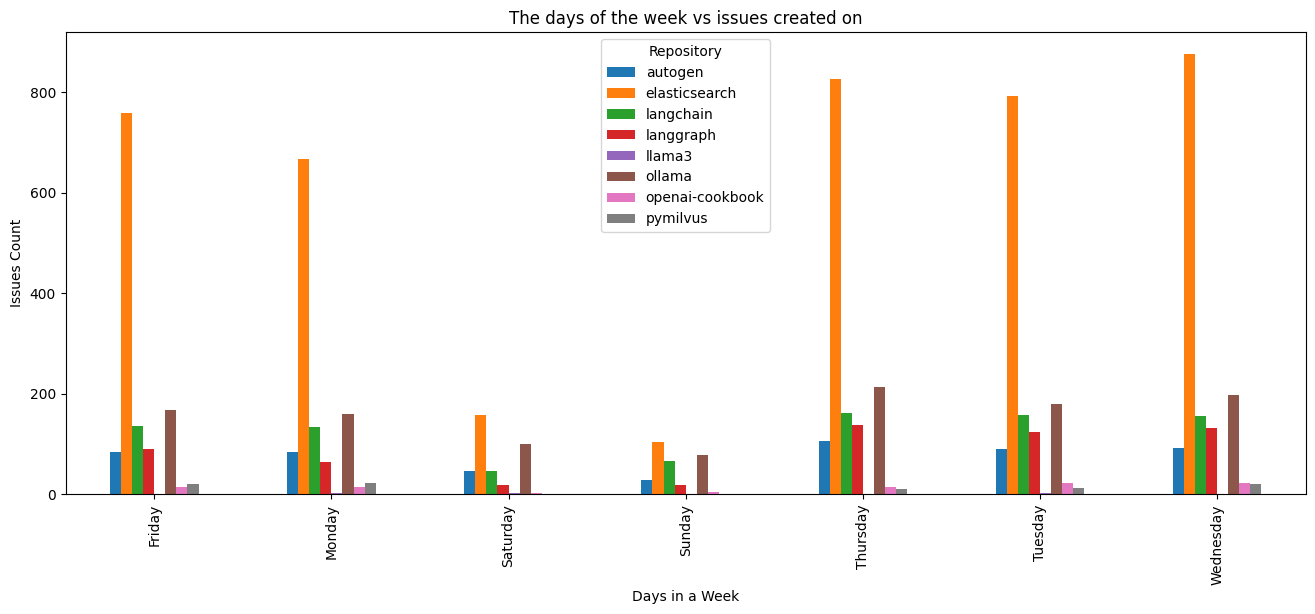

In [47]:
figure, ax = plt.subplots(figsize=(16, 6))

issues_DF.T.plot(kind="bar", ax = ax)
plt.title("The days of the week vs issues created on")
plt.xlabel("Days in a Week")
plt.ylabel("Issues Count")
plt.legend(title="Repository")

---

## PART - II

## llama3

In [48]:
repoName = "llama3"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the llama3 repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:llama3
Issue Number: 396
Title: Difficulty Accessing Llama-3.1, 3.2, 3.3, and Llama 4.
Created At: 2025-04-08T15:31:19Z
Closed At: 2024-12-31T00:36:30Z
State: open
Body: I tried accessing the Llama Models through Hugging Face and all the models later than and including Llama 3.1 failed. I am getting an error saying that I don't have permission to access the repository. I tried accessing them on the Llama website and it also failed. 


Type: issue
Repo:llama3
Issue Number: 398
Title: 250425_model.py training mode update
Created At: 2025-04-25T08:50:34Z
Closed At: 2025-04-25T08:51:22Z
State: closed
Body: None


Type: issue
Repo:llama3
Issue Number: 397
Title: A TEST file
Created At: 2025-04-15T20:30:15Z
Closed At: 2024-12-31T00:36:30Z
State: open
Body: Simply testing


Type: issue
Repo:llama3
Issue Number: 395
Title: How to SFT llama3 with a labelled dataset
Creat

## ollama

In [49]:
repoName = "ollama"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the ollama repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:ollama
Issue Number: 9681
Title: Update base image from Ubuntu 20.24 to 24.04 LTS
Created At: 2025-03-12T09:11:54Z
Closed At: 2025-04-14T15:05:07Z
State: closed
Body: Ollama actually use Ubuntu 20.04 LTS that is arriving to it's end of life.
Upgrading to Ubuntu 24.04 LTS.
Address issue #9679


Type: issue
Repo:ollama
Issue Number: 9613
Title: Make manual updates an option
Created At: 2025-03-09T17:30:06Z
Closed At: 2024-12-31T00:36:30Z
State: open
Body: Use case. Build 0.5.13 seems to be broken for gfx1151 and so I need to stay on previous release. 
Besides that, Ollama is the best thing since sliced ​​bread :) 


Type: issue
Repo:ollama
Issue Number: 10190
Title: llama vs ollama
Created At: 2025-04-09T03:59:21Z
Closed At: 2025-04-09T05:02:16Z
State: closed
Body: ### What is the issue?

Hi all,
   recently, I tested llama.cpp (llama_cli) and ollama with llama3.2

## langchain

In [50]:
repoName = "langchain"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the langchain repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:langchain
Issue Number: 30557
Title: langchain: release 0.3.22
Created At: 2025-03-30T18:43:10Z
Closed At: 2025-03-30T18:48:22Z
State: closed
Body: Closes https://github.com/langchain-ai/langchain/issues/30536


Type: issue
Repo:langchain
Issue Number: 30916
Title: langchain deepseek : depends compatible question with langchain-commnunity because of version with langchain-core
Created At: 2025-04-18T03:18:59Z
Closed At: 2024-12-31T00:36:30Z
State: open
Body: ### Checked other resources

- [x] I added a very descriptive title to this issue.
- [x] I used the GitHub search to find a similar question and didn't find it.
- [x] I am sure that this is a bug in LangChain rather than my code.
- [x] The bug is not resolved by updating to the latest stable version of LangChain (or the specific integration package).
- [x] I posted a self-contained, minimal, reproducible 

## langgraph

In [51]:
repoName = "langgraph"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the langgraph repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:langgraph
Issue Number: 3602
Title: langgraph: release 0.2.75
Created At: 2025-02-26T16:47:09Z
Closed At: 2025-02-26T16:47:17Z
State: closed
Body: None


Type: issue
Repo:langgraph
Issue Number: 3609
Title: langgraph: release 0.2.76
Created At: 2025-02-26T21:41:18Z
Closed At: 2025-02-26T21:41:29Z
State: closed
Body: None


Type: issue
Repo:langgraph
Issue Number: 3883
Title: langgraph-checkpoint 2.0.21
Created At: 2025-03-17T22:15:55Z
Closed At: 2025-03-17T22:25:26Z
State: closed
Body: None


Type: issue
Repo:langgraph
Issue Number: 4204
Title: langgraph: release 0.3.26
Created At: 2025-04-08T17:57:20Z
Closed At: 2025-04-08T18:53:11Z
State: closed
Body: None


Type: issue
Repo:langgraph
Issue Number: 3633
Title: docs: update langgraph api constraints
Created At: 2025-02-27T18:59:29Z
Closed At: 2025-02-27T18:59:36Z
State: closed
Body: None



## autogen

In [52]:
repoName = "autogen"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the autogen repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:autogen
Issue Number: 6257
Title: .NET update autogen 0.2.2 -> autogen 0.2.3
Created At: 2025-04-09T17:36:23Z
Closed At: 2025-04-09T17:42:46Z
State: closed
Body: <!-- Thank you for your contribution! Please review https://microsoft.github.io/autogen/docs/Contribute before opening a pull request. -->

<!-- Please add a reviewer to the assignee section when you create a PR. If you don't have the access to it, we will shortly find a reviewer and assign them to your PR. -->

## Why are these changes needed?

<!-- Please give a short summary of the change and the problem this solves. -->

## Related issue number

<!-- For example: "Closes #1234" -->

## Checks

- [ ] I've included any doc changes needed for <https://microsoft.github.io/autogen/>. See <https://github.com/microsoft/autogen/blob/main/CONTRIBUTING.md> to build and test documentation locally.
- [ ] I've 

## openai-cookbook

In [53]:
repoName = "openai-cookbook"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the openai-cookbook repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:openai-cookbook
Issue Number: 1763
Title: Openai_learning
Created At: 2025-04-10T01:57:03Z
Closed At: 2025-04-10T01:57:33Z
State: closed
Body: - Created notebooks demonstrating how to use Typesense for embeddings search.
- Developed notebooks showcasing filtered search with Zilliz and OpenAI.
- Introduced a notebook for getting started with Zilliz and OpenAI.
- Implemented example scripts for making API calls to OpenAI.
- Enhanced responses.py to include a pirate-themed coding assistant.

## Summary

Briefly describe the changes and the goal of this PR. Make sure the PR title summarizes the changes effectively.

## Motivation

Why are these changes necessary? How do they improve the cookbook?

---

## For new content

When contributing new content, read through our [contribution guidelines](https://github.com/openai/openai-cookbook/blob/main/CONTRIBUTIN

## elasticsearch

In [54]:
repoName = "elasticsearch"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the elasticsearch repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:elasticsearch
Issue Number: 126818
Title: [8.x] License check for ES|QL categorize (#126595)
Created At: 2025-04-15T07:59:08Z
Closed At: 2025-04-15T09:04:37Z
State: closed
Body: Backports the following commits to 8.x:
 - License check for ES|QL categorize (#126595)


Type: issue
Repo:elasticsearch
Issue Number: 126857
Title: [8.x] [Failure Store] ES|QL security tests (#125586)
Created At: 2025-04-15T16:17:13Z
Closed At: 2025-04-15T17:27:28Z
State: closed
Body: Backports the following commits to 8.x:
 - [Failure Store] ES|QL security tests (#125586)


Type: issue
Repo:elasticsearch
Issue Number: 126835
Title: [8.18] License check for ES|QL categorize (#126595)
Created At: 2025-04-15T10:32:57Z
Closed At: 2025-04-15T11:46:13Z
State: closed
Body: backport #126595 


Type: issue
Repo:elasticsearch
Issue Number: 127132
Title: Update Elasticsearch main with snap

## pymilvus

In [55]:
repoName = "pymilvus"
question = f"Give me the Top 5 similar issues that are from the {repoName} repository from between {two_months_later} and {today}"
print(question)
question_embedding = get_embedding(question, model=EMBEDDING_MODEL)

response = es.search(
  index="github_issues",
  knn = {
      "field": "GitHub_Issue_vector",  
      "query_vector": question_embedding,
      "k": 5,
      "num_candidates": 100
    },
    query = {
        "bool": {
            "should": [
                { "match": {"_repo": f"{repoName}"}}
            ]
        }
    },
    size=5,
)

pretty_response_Issue(response)

Give me the Top 5 similar issues that are from the pymilvus repository from between 2025-02-25 and 2025-04-25

Type: issue
Repo:pymilvus
Issue Number: 2761
Title: [Bug]: GetFlushState may use the request_id of other requests such as upsert
Created At: 2025-04-25T09:59:37Z
Closed At: 2024-12-31T00:36:30Z
State: open
Body: ### Is there an existing issue for this?

- [x] I have searched the existing issues

### Describe the bug

 - pymilvus version: pymilvus-2.6.0rc91
 - test scene:
1.  Concurrent flush and upsert with fouram framework. The fouram generate requestId for each request. However, we found a  upsert request and a GetFlushState request have the same request id in milvus server logs.
![Image](https://github.com/user-attachments/assets/fe1421bc-aa26-467e-bc37-693a48300bc8)

2. According to fouram's debug log, this requests id only belongs to an upsert request.
log path: `/test/fouram/log/2025_04_24/zong-sn-scene-dml-aa-3_51157/fouram_log.debug`
(vim and filter by `:v/c880597b7643

## Sanity Test:

Execute following commands from the command window/terminal:

**To verify the index got created:**
- curl -XGET "http://localhost:9200/_cat/indices?v"

**To check the structure of index:**
- curl -X GET "localhost:9200/github_issues?pretty"

**To check the stats of the index:**

- curl -X GET "localhost:9200/github_issues/_stats?pretty"

**To dump the documents in the index to stdout:**
- curl -XGET "http://localhost:9200/github_issues/_search?pretty=true"

**To dump the mapping of  the index to stdout:**
- curl -XGET "localhost:9200/github_issues/_mapping?pretty"


## How to delete  the index?
**To delete the index you created:**
- curl -XDELETE "http://localhost:9200/github_issues?pretty"

